In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
n_epochs = 30
n_layers = 1
n_train = 100
n_test = 40

SAVE_PATH = "/content/quanvolution"
PREPROCESS = True           # False --> skip quantum processing and load data from SAVE_PATH
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension (for convolution channels)
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
np.shape(train_images)

(100, 28, 28, 1)

In [ ]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

# To convert the function into a QNode running on dev, we apply the qnode() decorator
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement (expect. val.) producing 4 classical outputs
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
q_train_images.shape

(100, 14, 14, 4)

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}        ", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}        ", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


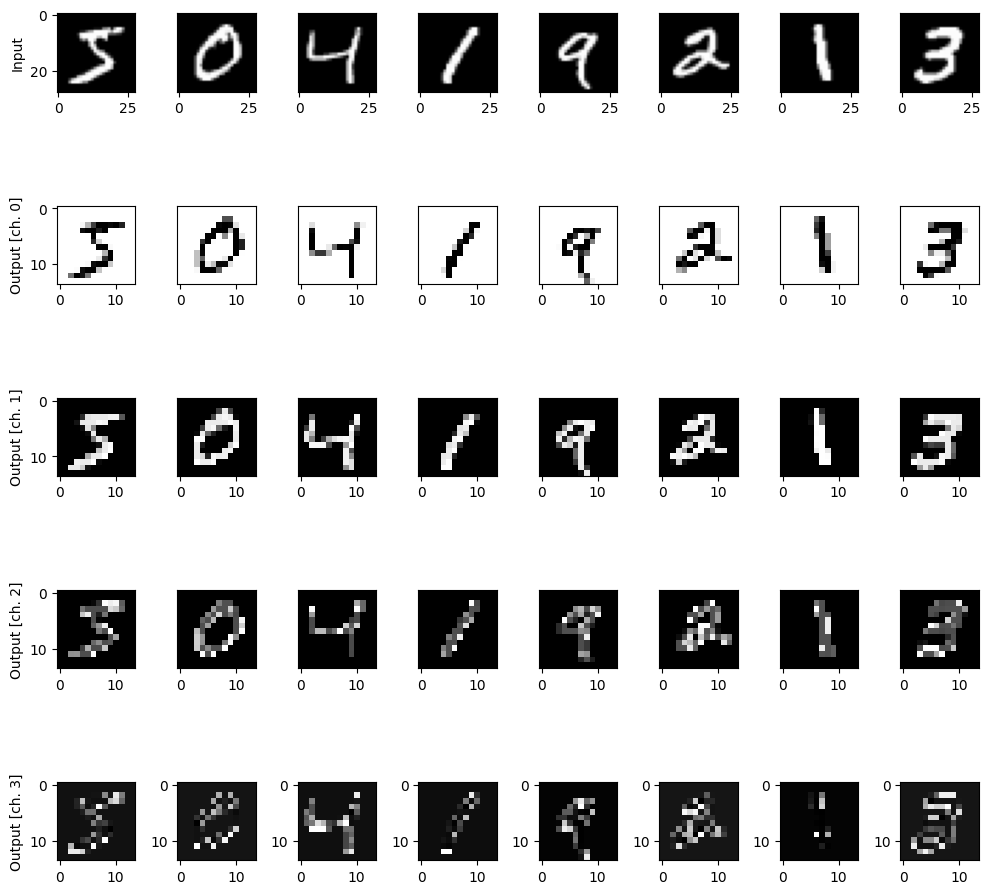

In [ ]:
n_samples = 8
n_channels = 4

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples.png', dpi=300, facecolor='w')
plt.show()

In [ ]:
def model():
    """Initializes and returns a Keras model to be trained"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = model()

q_history = q_model.fit(q_train_images, train_labels,
                        validation_data=(q_test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

In [ ]:
c_model = model()

c_history = c_model.fit(train_images, train_labels,
                        validation_data=(test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

<ipython-input-13-07dacc7673cc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


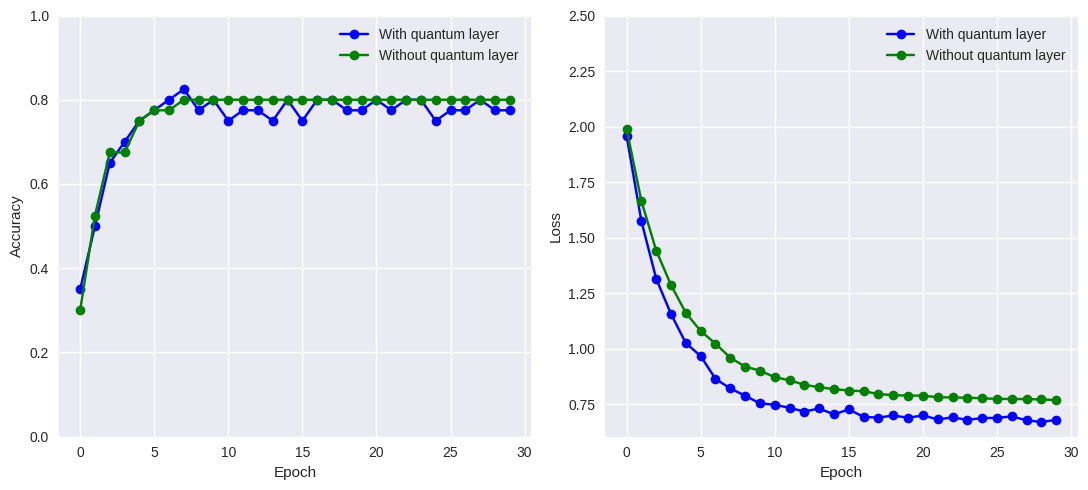

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png', dpi=200, facecolor='w')
plt.show()